data source : https://www.kaggle.com/wendykan/lending-club-loan-data

In [2]:
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
import pandas as pd
import numpy as np

from statistics import mean
import re

In [3]:
# Define custom method
def desc_encode(desc):
    index = desc[0]
    desc = desc[1]
    l = 0
    entries = 0
    if type(desc["desc"]) == str: 
        matches = re.findall(r"(Borrower added on .* >)(.*)", desc["desc"].replace("<br>", "\n"))
        entries = (len(matches))
        for match in matches:
            l += len(match[1])
    return (index, l, entries)

In [4]:
# turn csv data file to pandas DataFrame
full_raw_data = pd.read_csv(r"/home/tommybox/Desktop/lending-club-loan-data/loan.csv", low_memory=False)

In [5]:
# pull required columns out of full_raw_data DataFrame
cols = [
    "loan_amnt",
    "funded_amnt",
    "term",
    "installment",
    "emp_length",
    "home_ownership",
    "annual_inc",
    "loan_status",
    "purpose",
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "int_rate",   
    "total_pymnt",
    "desc"    
]
raw_data = full_raw_data[cols]

In [6]:
# Clean Data
data = raw_data[:]
# return int of months of the loan duration
data["term"] = data["term"].apply(lambda x: int(re.findall("\d+", x)[0]))
# Remove unwanted loans based on homeownership, , loan status, loan duration, and funding completion
removed_unwanted_rows = data[
    ((data["home_ownership"] == "MORTGAGE") | (data["home_ownership"] == "RENT") | (data["home_ownership"] == "OWN")) &
    ((data["loan_status"] == "Charged Off") | (data["loan_status"] == "Fully Paid") | (data["loan_status"] == "Default")) &
    (data["term"] == 36) &
    (data["loan_amnt"] == data["funded_amnt"])
    ]
removed_unwanted_cols = removed_unwanted_rows.drop(["term", "funded_amnt"], axis=1)
# Clean Employment length to return int 0-10
removed_unwanted_cols["emp_length"].fillna("0", inplace=True)
removed_unwanted_cols["emp_length"] = pd.to_numeric(removed_unwanted_cols["emp_length"].apply(lambda x: re.findall("\d+", x)[0]))
# Create required datapoints 
removed_unwanted_cols["payment_ratio"] = removed_unwanted_cols["annual_inc"]/removed_unwanted_cols["installment"]
removed_unwanted_cols["roi"] = removed_unwanted_cols["total_pymnt"]/removed_unwanted_cols["loan_amnt"]
# One Hot Encode Home Ownership ans purpose
own = pd.get_dummies(removed_unwanted_cols["home_ownership"])
purpose = pd.get_dummies(removed_unwanted_cols["purpose"])
# Quantify description
desc_code = pd.DataFrame(list(map(desc_encode, removed_unwanted_cols.iterrows())), columns=["indx", "desc_len", "desc_entry_count"]).set_index('indx')
# Final concat/clean
raw_final = removed_unwanted_cols.drop(["installment", "purpose", "desc", "home_ownership", "loan_status", "total_pymnt"], axis=1)
final = raw_final.join(own).join(purpose).join(desc_code)
final = final.dropna()

In [7]:
goal = final["roi"].mean()
print(goal)

1.042453391139412


In [8]:
# Manual Train/Set Split
shuffled_data = final.sample(frac=1)
split = .75
split_int = int(len(shuffled_data)*split)
test = shuffled_data[split_int:]
train = shuffled_data[:split_int]

In [9]:
# Remove outliers
drop = train[train["annual_inc"]>200000].index
train = train.drop(drop)

drop = train[train["payment_ratio"]>200000].index
train = train.drop(drop)

drop = train[train["desc_len"]>2000].index
train = train.drop(drop)

In [10]:
X = train.drop(["roi"], axis=1)
y = train["roi"]

In [11]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [12]:
model = SGDRegressor()
model.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [13]:
# Scale/Prep test Data
test_input = test.drop(["roi"], axis=1)
X_test = scaler.transform(test_input)
y_test = test["roi"]

In [14]:
y_pred = model.predict(X_test)

In [15]:
# Create a DataFrame to find a threshold that returns best ROI on a resonable percent of loans
log = []
ln = len(y_pred)
for thr in np.linspace(.9, 1.2, num=100):
    l = []
    for i, pred in enumerate(y_pred):
        if pred > thr:
            l.append(test.iloc[i]["roi"])

    log.append((thr, mean(l) if len(l) != 0 else 0, len(l), len(l)/ln))    

logs = pd.DataFrame(log, columns = ["threshold", "roi_avg", "amount", "amt_percent"])

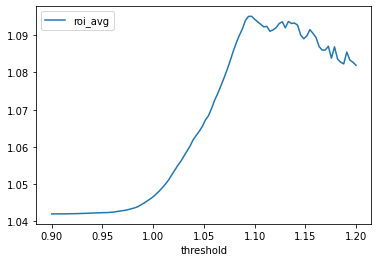

In [17]:
logs.plot.line(y="roi_avg", x="threshold")

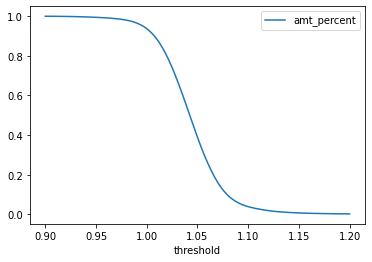

In [18]:
logs.plot.line(x="threshold", y="amt_percent")

In [19]:
thr = 1.077
approved_loans= test[y_pred>thr]

In [20]:
approved_loans.describe()

,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,int_rate,payment_ratio,roi,MORTGAGE,...,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,desc_len,desc_entry_count
count,27511.00000,27511.000000,2.751100e+04,27511.000000,27511.000000,27511.000000,27511.000000,27511.000000,27511.000000,27511.000000,...,27511.000000,27511.000000,27511.000000,27511.000000,27511.0,27511.000000,27511.000000,27511.000000,27511.000000,27511.000000
mean,11737.13969,7.421395,7.697051e+04,13.537920,0.185562,0.445822,10.034260,260.612775,1.084215,0.707244,...,0.033587,0.002872,0.002217,0.075315,0.0,0.002108,0.000945,0.017593,105.309331,0.704409
std,6681.01062,3.282527,4.964036e+04,7.032896,0.571837,0.778879,3.517175,216.564970,0.176055,0.455035,...,0.180166,0.053511,0.047037,0.263904,0.0,0.045868,0.030728,0.131469,171.651573,0.767673
min,1000.00000,0.000000,4.200000e+03,0.000000,0.000000,0.000000,5.310000,40.837162,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6800.00000,5.000000,4.825550e+04,8.220000,0.000000,0.000000,7.260000,135.315886,1.069162,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10000.00000,10.000000,6.616400e+04,12.880000,0.000000,0.000000,9.170000,197.251627,1.110140,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,38.000000,1.000000
75%,15000.00000,10.000000,9.300000e+04,18.245000,0.000000,1.000000,12.350000,307.121515,1.164300,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,159.000000,1.000000
max,40000.00000,10.000000,1.500000e+06,35.760000,22.000000,7.000000,25.820000,3003.465537,1.426145,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,3594.000000,28.000000
